In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from concat_quoter_utc_toFeather import ConcatQuoterUtcToFeather

In [2]:
# Folder for binary df
folder_name = 'temp_df'
file_name = 'df.feather'
file_path = os.path.join(folder_name, file_name)

if not os.path.exists(file_path):
    create_feather_file = ConcatQuoterUtcToFeather(folder_name, file_name)
    create_feather_file.concat_quoter_utc()

In [3]:
df = pd.read_feather(file_path)
df['Time'] = pd.to_datetime(df['Time'], utc=True).dt.tz_convert('Europe/Stockholm')
df.set_index('Time', inplace=True)
print(df.info())
print(df.head(5))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85705211 entries, 2020-12-31 23:00:00+01:00 to 2023-09-29 23:00:00+02:00
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Value   float64
dtypes: float64(1)
memory usage: 1.3 GB
None
                            Value
Time                             
2020-12-31 23:00:00+01:00  49.999
2020-12-31 23:00:01+01:00  49.999
2020-12-31 23:00:02+01:00  49.997
2020-12-31 23:00:03+01:00  49.995
2020-12-31 23:00:04+01:00  49.994


### Filtering and setup

In [4]:
df['Value'] = df['Value'][df['Value'] != -1]
df['deviation'] = (df['Value'] < 49.9) | (df['Value'] > 50.1) # TODO take into account if the deviation is a upper or lower value.
df['deviation_count'] = df['deviation'].astype(int)
disturbance_count_yearly = df['deviation_count'].resample('Y').sum()
disturbance_count_day = df['deviation_count'].resample('D').sum()
disturbance_count_week = df['deviation_count'].resample('W').sum()
disturbance_count_month = df['deviation_count'].resample('M').sum()

df['deviation_duration'] = df['deviation_count'].groupby(df['deviation'].ne(df['deviation'].shift()).cumsum()).cumsum()
df['deviation_duration'] = df['deviation_duration'][df['deviation_duration'] != 0]

disturbance_duration_day = df['deviation_duration'].resample('D').mean()
disturbance_duration_week = df['deviation_duration'].resample('W').mean()
disturbance_duration_month = df['deviation_duration'].resample('M').mean()

df['hour'] = df.index.hour
disturbance_duration_hour = df.groupby('hour')['deviation_duration'].mean()

In [8]:
df

,Value,deviation,deviation_count,deviation_duration,hour
Time,,,,,
2020-12-31 23:00:00+01:00,49.999,False,0,NaN,23
2020-12-31 23:00:01+01:00,49.999,False,0,NaN,23
2020-12-31 23:00:02+01:00,49.997,False,0,NaN,23
2020-12-31 23:00:03+01:00,49.995,False,0,NaN,23
2020-12-31 23:00:04+01:00,49.994,False,0,NaN,23
...,...,...,...,...,...
2023-09-29 22:59:56+02:00,NaN,False,0,NaN,22
2023-09-29 22:59:57+02:00,NaN,False,0,NaN,22
2023-09-29 22:59:58+02:00,NaN,False,0,NaN,22


### Disturbance Counts

Yearly

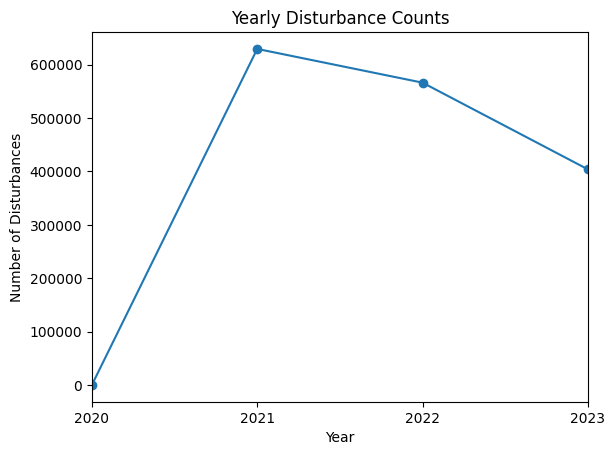

In [9]:
disturbance_count_yearly.plot(kind='line', marker='o')
plt.title('Yearly Disturbance Counts')
plt.xlabel('Year')
plt.ylabel('Number of Disturbances')
plt.show()

Day, week, month

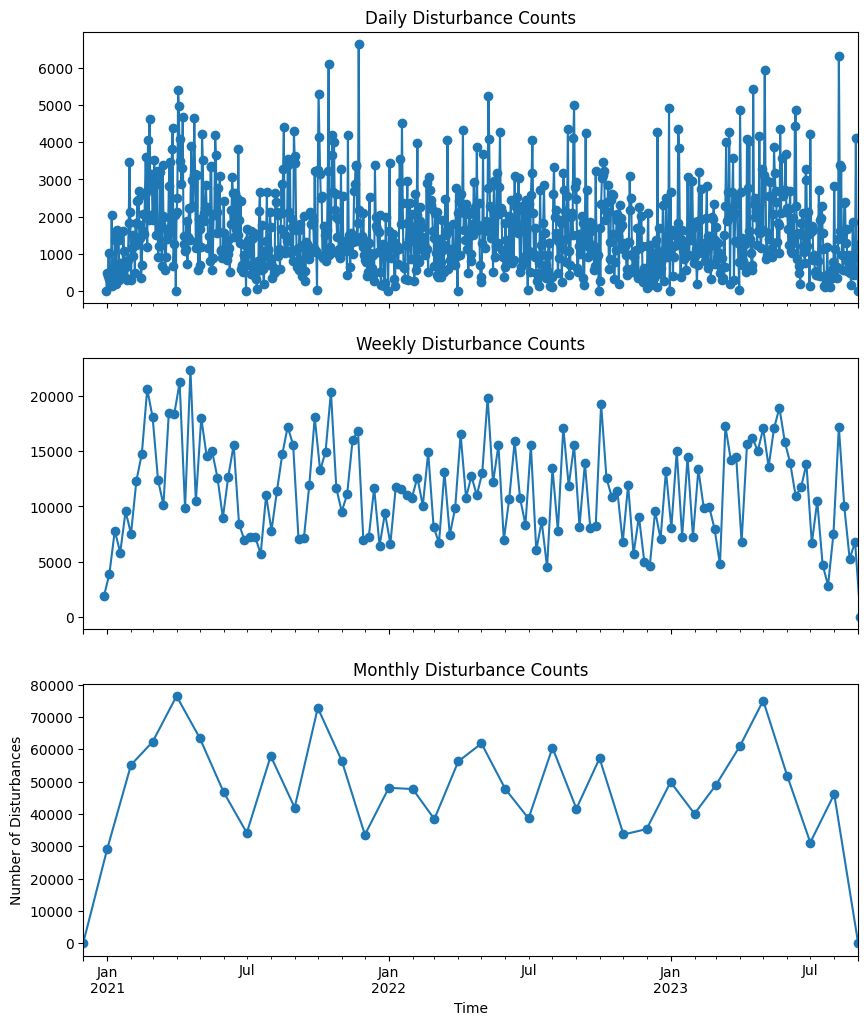

In [10]:
fig, axes = plt.subplots(nrows=3, figsize=(10, 12), sharex=True)

disturbance_count_day.plot(ax=axes[0], title='Daily Disturbance Counts', marker='o')
disturbance_count_week.plot(ax=axes[1], title='Weekly Disturbance Counts', marker='o')
disturbance_count_month.plot(ax=axes[2], title='Monthly Disturbance Counts', marker='o')

plt.xlabel('Time')
plt.ylabel('Number of Disturbances')
plt.show()

### Disturbance Duration

All time

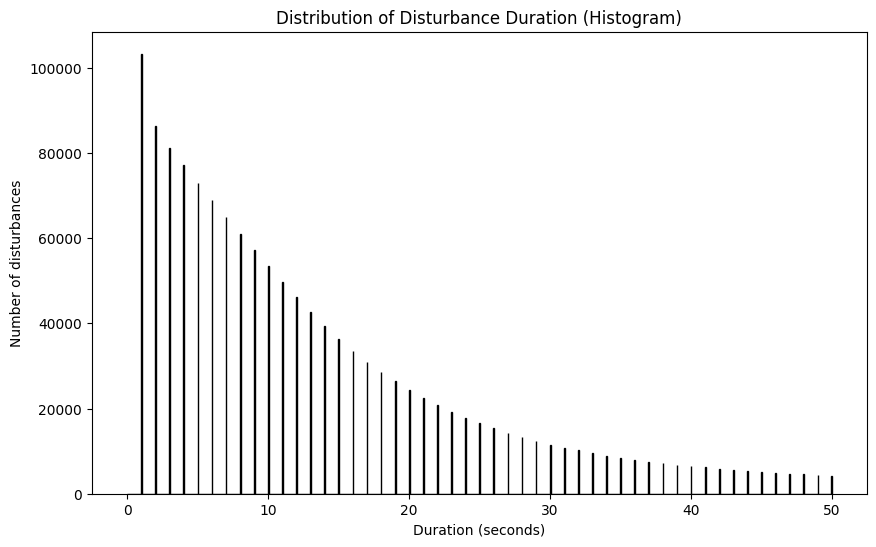

In [17]:
plt.figure(figsize=(10, 6))

df['deviation_duration'].plot(kind='hist', bins=1000, range=(0, 50), edgecolor='black')

plt.title('Distribution of Disturbance Duration (Histogram)')
plt.xlabel('Duration (seconds)')
plt.ylabel('Number of disturbances')

plt.show()

Day, week, month

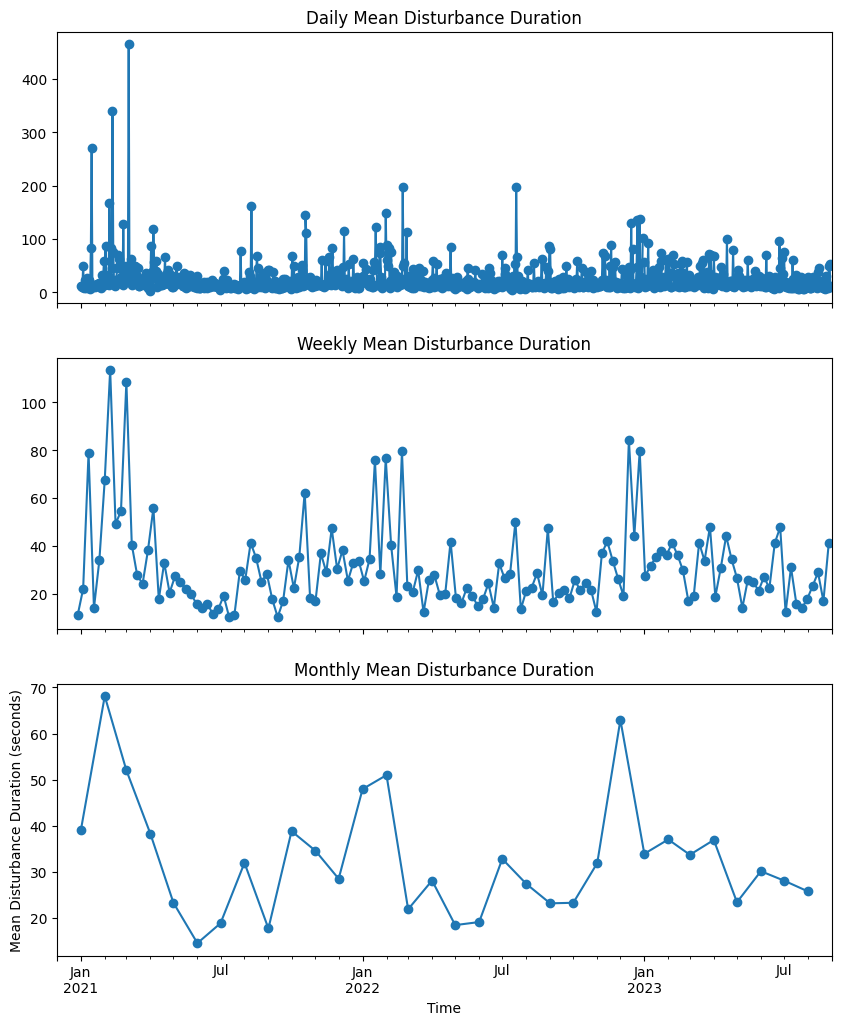

In [12]:
fig, axes = plt.subplots(nrows=3, figsize=(10, 12), sharex=True)

disturbance_duration_day.plot(ax=axes[0], title='Daily Mean Disturbance Duration', marker='o')
disturbance_duration_week.plot(ax=axes[1], title='Weekly Mean Disturbance Duration', marker='o')
disturbance_duration_month.plot(ax=axes[2], title='Monthly Mean Disturbance Duration', marker='o')

plt.xlabel('Time')
plt.ylabel('Mean Disturbance Duration (seconds)')
plt.show()

Hour

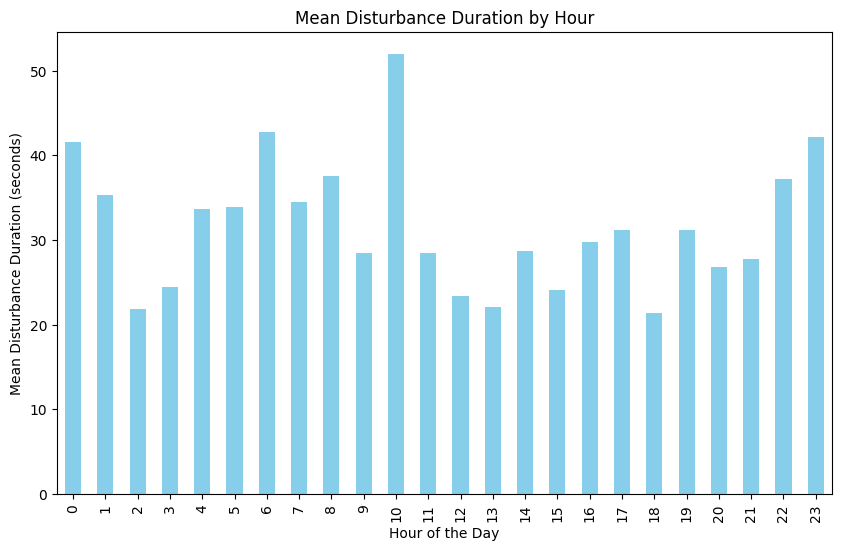

In [13]:
disturbance_duration_hour.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Mean Disturbance Duration by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Disturbance Duration (seconds)')
plt.show()